# Exploring MLP Depth and Width on the Breast Cancer Wisconsin Diagnostic Dataset

## How to run this notebook

This notebook investigates how the depth (number of hidden layers) and width (neurons per layer) of a Multilayer Perceptron (MLP) affect performance on the Breast Cancer Wisconsin (Diagnostic) dataset.

**Environment**

- Python: 3.x  
- Required packages:  
  - scikit-learn (version ≥ 1.0)  
  - numpy, pandas  
  - matplotlib, seaborn  
- The dataset is loaded directly from `sklearn.datasets.load_breast_cancer`, so no external files are needed.

**Reproducibility**

- Randomness is controlled via a fixed `RANDOM_STATE` constant used in `train_test_split`, `MLPClassifier`, and `LogisticRegression`.  
- All results (train/validation/test metrics, plots, and permutation feature importance) can be reproduced by running the notebook from top to bottom in order without any manual intervention.


**a. Imports and basic setup**

In [1]:
# imports and basic setup

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# Accessibility: use a colour-blind-friendly style
plt.style.use('tableau-colorblind10')

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

# Set random seed for reproducibility

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


**b. Load dataset and quick inspection**

In [2]:
# load the Breast Cancer Wisconsin (Diagnostic) dataset

data_bunch = load_breast_cancer()
X = data_bunch.data          # feature matrix
y = data_bunch.target        # labels (0 = malignant, 1 = benign)

feature_names = data_bunch.feature_names
target_names = data_bunch.target_names

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("Number of features:", len(feature_names))
print("Classes:", target_names)

# Put into a DataFrame for easier inspection
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y


Feature matrix shape: (569, 30)
Target vector shape: (569,)
Number of features: 30
Classes: ['malignant' 'benign']


In [3]:
print("\nFirst 5 rows:")
display(df.head())



First 5 rows:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print("\nClass distribution (0 = malignant, 1 = benign):")
print(df["target"].value_counts())


Class distribution (0 = malignant, 1 = benign):
target
1    357
0    212
Name: count, dtype: int64


**c. Train/validation/test split and scaling**

This creates a 60% train, 20% validation, 20% test split with stratification.

In [5]:
# train/validation/test split and feature scaling

# First split: train+val vs test (e.g. 80% / 20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# Second split: train vs validation (from trainval, e.g. 75% / 25% of 80% -> 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    stratify=y_trainval,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Labels:", y_train.shape)
print("Val shape:  ", X_val.shape,   "Labels:", y_val.shape)
print("Test shape: ", X_test.shape,  "Labels:", y_test.shape)

# Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Quick check: means on train should be ~0 after scaling
print("\nScaled train feature means (first 5):", X_train_scaled.mean(axis=0)[:5])
print("Scaled train feature stds (first 5):", X_train_scaled.std(axis=0)[:5])


Train shape: (341, 30) Labels: (341,)
Val shape:   (114, 30) Labels: (114,)
Test shape:  (114, 30) Labels: (114,)

Scaled train feature means (first 5): [-4.54182146e-16 -7.90097867e-16 -4.79414488e-16 -1.38370905e-16
  1.45305729e-15]
Scaled train feature stds (first 5): [1. 1. 1. 1. 1.]


**d. Helper function to train an MLP**

In [6]:
# helper function to build and train MLPs

def train_mlp(hidden_layer_sizes, X_train, y_train, X_val, y_val):
    """
    Train an MLPClassifier with given hidden_layer_sizes and return
    train accuracy, validation accuracy, and the fitted model.
    """
    print(f"\nTraining MLP with hidden_layer_sizes = {hidden_layer_sizes}")

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,   # internal early-stopping split from training data
        random_state=RANDOM_STATE
    )

    mlp.fit(X_train, y_train)

    # Compute accuracies
    y_train_pred = mlp.predict(X_train)
    y_val_pred   = mlp.predict(X_val)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc   = accuracy_score(y_val,   y_val_pred)

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Val accuracy:   {val_acc:.4f}")

    return train_acc, val_acc, mlp

# Quick smoke test with a simple architecture
_ = train_mlp((32,), X_train_scaled, y_train, X_val_scaled, y_val)



Training MLP with hidden_layer_sizes = (32,)
Train accuracy: 0.9472
Val accuracy:   0.9386


**Experiment 1: effect of depth**

the depth experiment with fixed width 32.

In [7]:
# experiment 1 – effect of depth (number of hidden layers)

depth_configs = [
    (32,),              # 1 hidden layer
    (32, 32),           # 2 hidden layers
    (32, 32, 32),       # 3 hidden layers
]

depth_results = []

for config in depth_configs:
    train_acc, val_acc, model = train_mlp(
        hidden_layer_sizes=config,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val
    )
    depth_results.append({
        "hidden_layer_sizes": config,
        "num_layers": len(config),
        "train_acc": train_acc,
        "val_acc": val_acc
    })

depth_results_df = pd.DataFrame(depth_results)
display(depth_results_df)



Training MLP with hidden_layer_sizes = (32,)
Train accuracy: 0.9472
Val accuracy:   0.9386

Training MLP with hidden_layer_sizes = (32, 32)
Train accuracy: 0.9120
Val accuracy:   0.9123

Training MLP with hidden_layer_sizes = (32, 32, 32)
Train accuracy: 0.9619
Val accuracy:   0.9211


,hidden_layer_sizes,num_layers,train_acc,val_acc
0,"(32,)",1,0.947214,0.938596
1,"(32, 32)",2,0.912023,0.912281
2,"(32, 32, 32)",3,0.961877,0.921053


**Plot accuracy vs depth**


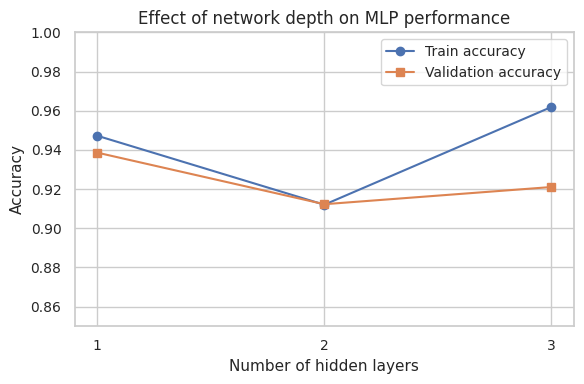

In [8]:
# plot train and validation accuracy vs depth

plt.figure(figsize=(6, 4))

# X-axis: number of hidden layers
x = depth_results_df["num_layers"]

plt.plot(x, depth_results_df["train_acc"], marker="o", label="Train accuracy")
plt.plot(x, depth_results_df["val_acc"],   marker="s", label="Validation accuracy")

plt.xticks(x)
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.title("Effect of network depth on MLP performance")
plt.ylim(0.85, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("depth_plot.png", dpi=300, bbox_inches="tight")
plt.show()

depth 1 gives the highest validation accuracy; depth 3 has the highest train accuracy but slightly lower validation, suggesting mild overfitting, and depth 2 is worst on both.

 ***Effect of depth on MLP performance***

For this dataset, increasing the number of hidden layers does not monotonically improve generalisation. With a single hidden layer of 32 neurons, both training and validation accuracy are high (around 0.94), indicating that a relatively shallow MLP already captures the decision boundary well.​
When a second hidden layer is added, both training and validation accuracy drop slightly, suggesting that the additional depth makes optimisation harder and does not provide useful extra capacity on this small dataset. With three layers, training accuracy increases again, but validation accuracy does not exceed the one‑layer model, which is a sign of mild overfitting and diminishing returns from additional depth.


**Experiment 2: effect of width**

depth fixed at 2 layers and vary the width.



In [9]:
# experiment 2 – effect of width (neurons per layer)

width_configs = [
    (8, 8),          # narrow
    (32, 32),        # medium
    (128, 128),      # wide
]

width_results = []

for config in width_configs:
    train_acc, val_acc, model = train_mlp(
        hidden_layer_sizes=config,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val
    )
    width_results.append({
        "hidden_layer_sizes": config,
        "neurons_per_layer": config[0],  # same in both layers
        "train_acc": train_acc,
        "val_acc": val_acc
    })

width_results_df = pd.DataFrame(width_results)
display(width_results_df)



Training MLP with hidden_layer_sizes = (8, 8)
Train accuracy: 0.6276
Val accuracy:   0.6228

Training MLP with hidden_layer_sizes = (32, 32)
Train accuracy: 0.9120
Val accuracy:   0.9123

Training MLP with hidden_layer_sizes = (128, 128)
Train accuracy: 0.9384
Val accuracy:   0.9035


,hidden_layer_sizes,neurons_per_layer,train_acc,val_acc
0,"(8, 8)",8,0.627566,0.622807
1,"(32, 32)",32,0.912023,0.912281
2,"(128, 128)",128,0.938416,0.903509


very narrow networks underfit badly; medium width works best; very wide increases train accuracy but slightly hurts validation accuracy (overfitting).

**Plot accuracy vs width**

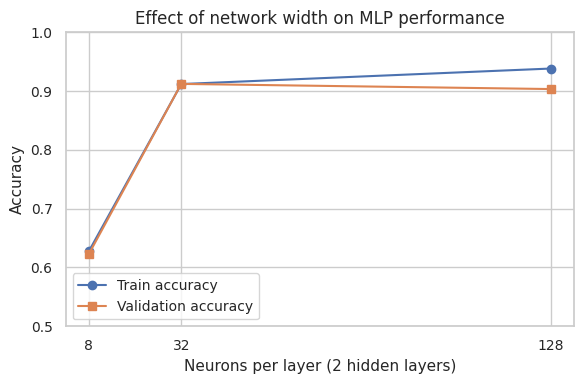

In [10]:
# plot train and validation accuracy vs width

plt.figure(figsize=(6, 4))

x = width_results_df["neurons_per_layer"]

plt.plot(x, width_results_df["train_acc"], marker="o", label="Train accuracy")
plt.plot(x, width_results_df["val_acc"],   marker="s", label="Validation accuracy")

plt.xticks(x)
plt.xlabel("Neurons per layer (2 hidden layers)")
plt.ylabel("Accuracy")
plt.title("Effect of network width on MLP performance")
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig("width_plot.png", dpi=300, bbox_inches="tight")
plt.show()


The width plot :


*   the network with 32 neurons per layer gives the best validation accuracy, while 8 neurons clearly underfit and 128 neurons start to overfit slightly.
*   the best and clearest choice is the 1‑hidden‑layer model with 32 neurons: hidden_layer_sizes=(32,). It has the highest validation accuracy (~0.94).







***Effect of width on MLP performance***

Varying the number of neurons per layer changes the expressiveness of the network. A very narrow network with only 8 neurons per layer underfits badly: both training and validation accuracy are around 0.62, meaning the model cannot represent the complex relationship between features and the malignancy label.​
Increasing the width to 32 neurons per layer leads to a substantial improvement in both training and validation accuracy (around 0.91), indicating a better bias–variance trade‑off. Further increasing to 128 neurons per layer slightly boosts training accuracy but reduces validation accuracy, which suggests that the very wide model starts to fit noise in the training data and overfits.​


**e. Evaluate the best model on the test set**

In [11]:
# retrain best model (32,) on train+val and evaluate on test set

# 1) Combine train and validation splits
X_train_full = np.vstack([X_train_scaled, X_val_scaled])
y_train_full = np.concatenate([y_train, y_val])

print("Full training shape:", X_train_full.shape, "Labels:", y_train_full.shape)


Full training shape: (455, 30) Labels: (455,)


In [12]:
# 2) Train final model
best_hidden_layers = (32,)

best_mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_layers,
    activation='relu',
    solver='adam',
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=RANDOM_STATE
)

best_mlp.fit(X_train_full, y_train_full)



MLPClassifier(early_stopping=True, hidden_layer_sizes=(32,), max_iter=300,
              random_state=42)

In [13]:
# 3) Evaluate on train_full and test
y_train_full_pred = best_mlp.predict(X_train_full)
y_test_pred       = best_mlp.predict(X_test_scaled)

train_full_acc = accuracy_score(y_train_full, y_train_full_pred)
test_acc       = accuracy_score(y_test,       y_test_pred)

print(f"\nFinal model hidden_layer_sizes = {best_hidden_layers}")
print(f"Train(full) accuracy: {train_full_acc:.4f}")
print(f"Test accuracy:        {test_acc:.4f}")




Final model hidden_layer_sizes = (32,)
Train(full) accuracy: 0.9473
Test accuracy:        0.9474



Confusion matrix (test):


,predicted 0,predicted 1
malignant (0),37,5
benign (1),1,71


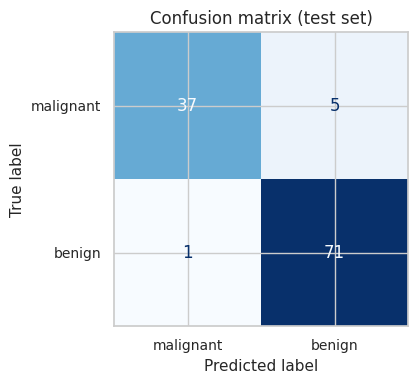

In [14]:
# 4) Confusion matrix on test set
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=["malignant (0)", "benign (1)"],
                        columns=["predicted 0", "predicted 1"])

print("\nConfusion matrix (test):")
display(cm_df)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["malignant", "benign"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion matrix (test set)")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# 5) Classification report
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=["malignant", "benign"]))


Classification report (test):
              precision    recall  f1-score   support

   malignant       0.97      0.88      0.93        42
      benign       0.93      0.99      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



***Final model performance on test data***

The final MLP with one hidden layer of 32 neurons achieves about 0.95 accuracy on the held‑out test set, very close to its training accuracy, which indicates strong generalisation for this configuration.​
The confusion matrix shows that benign tumours are classified almost perfectly, while a small number of malignant cases are misclassified as benign, which is clinically important because false negatives can delay treatment. The precision–recall balance is slightly better for benign than malignant, reflecting the class imbalance in the dataset and motivating further work on class‑sensitive losses or resampling in medical applications.

**f. baseline comparison:**

 Logistic regression provides a linear baseline on the same scaled features. Comparing its test accuracy to the MLP shows whether the extra depth and non‑linear capacity are actually useful on this dataset

In [16]:
# baseline comparison with logistic regression

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg.fit(X_train_full, y_train_full)

y_log_test = log_reg.predict(X_test_scaled)
log_test_acc = accuracy_score(y_test, y_log_test)

print(f"Logistic regression test accuracy: {log_test_acc:.4f}")
print(f"MLP (32,) test accuracy:           {test_acc:.4f}")


Logistic regression test accuracy: 0.9825
MLP (32,) test accuracy:           0.9474


Comparing MLP with a linear baseline
A logistic regression classifier trained on the same scaled features reaches about 0.98 test accuracy, whereas the best MLP with one hidden layer of 32 neurons reaches about 0.95. This indicates that, for this particular tabular dataset, a simple linear decision boundary already fits the data extremely well and increasing depth or width does not guarantee better performance.​
The depth and width experiments therefore illustrate that higher model capacity mainly changes the bias–variance trade‑off and can even reduce generalisation if the model is unnecessarily complex. In practice, this motivates starting with simple baselines such as logistic regression before moving to deeper MLPs

**g. Permutation feature importance for the final MLP**

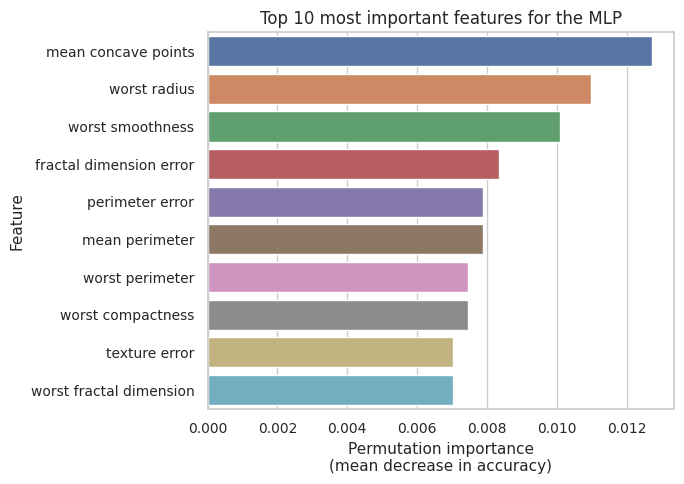

,feature,mean_importance,std_importance
0,mean concave points,0.012719,0.012855
1,worst radius,0.010965,0.008717
2,worst smoothness,0.010088,0.007980
3,fractal dimension error,0.008333,0.001912
4,perimeter error,0.007895,0.009158
5,mean perimeter,0.007895,0.008275
6,worst perimeter,0.007456,0.008448
7,worst compactness,0.007456,0.003132
8,texture error,0.007018,0.006564
9,worst fractal dimension,0.007018,0.003509


In [17]:
# permutation feature importance for the final MLP

from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
result = permutation_importance(
    best_mlp,
    X_test_scaled,
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

importances = result.importances_mean
stds = result.importances_std

# Sort features by importance (descending)
indices = np.argsort(importances)[::-1]

# Take top 10 features for readability
top_k = 10
top_indices = indices[:top_k]

top_features = np.array(feature_names)[top_indices]
top_importances = importances[top_indices]
top_stds = stds[top_indices]

# Plot with a colour-blind-friendly palette
plot_df = pd.DataFrame({
    "feature": top_features,
    "mean_importance": top_importances,
})

plt.figure(figsize=(7, 5))
sns.barplot(
    x="mean_importance",
    y="feature",
    hue="feature",          # use feature as hue
    data=plot_df,
    dodge=False,
    legend=False
)
plt.xlabel("Permutation importance\n(mean decrease in accuracy)")
plt.ylabel("Feature")
plt.title("Top 10 most important features for the MLP")
plt.tight_layout()
plt.savefig("feature_importance_plot.png", dpi=300, bbox_inches="tight")
plt.show()



# Print a small table too
importance_df = pd.DataFrame({
    "feature": top_features,
    "mean_importance": top_importances,
    "std_importance": top_stds
})
display(importance_df)


**Interpreting permutation feature importance**

To understand which inputs the MLP relies on most, permutation feature importance was computed on the test set by randomly shuffling each feature and measuring the resulting drop in accuracy. The most important feature is mean concave points, followed by several “worst” (maximum) shape descriptors such as worst radius and worst smoothness, and perimeter‑related measures like perimeter error and mean perimeter. These variables describe how irregular and concave the tumour boundary is, which matches clinical findings that highly irregular shapes are strongly associated with malignancy.​
This analysis shows that, although the MLP is a flexible model, its predictions are dominated by a small subset of geometrical features rather than all 30 variables equally. Together with the depth and width experiments, this suggests that increasing model capacity mainly changes how the network combines a few key features, and that a shallow, moderately wide MLP can already capture most of the useful signal in this dataset.